## Experiment to Visualize LFP Decision Boundaries on Toy Data

### Imports

In [1]:
import click
import os
import joblib
import json
import random
import copy
import logging
from tqdm import tqdm
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import matplotlib.pyplot as plt
import numpy as np
import torch
import os

from lfp.model import models as models
from lfp.data import transforms as transforms
from lfp.data import datasets as datasets
from lfp.data import dataloaders as dataloaders
from lfp.propagation import propagator_lxt as propagator
from lfp.propagation import make_composites
from lfp.utils import arguments as argument_utils
from lfp.evaluation import evaluate as evaluate
from lfp.rewards import rewards as rewards
from main import COMPOSITE_MAPPING, register_backward_normhooks

### Experiment Variables

In [2]:
dataset_name = "blobs"
n_channels = 2
model_name = "toydata-dense"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128
lrs=np.sort(np.array([np.arange(1, 11, 1, dtype=float)*10**x for x in [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3]]).flatten())
momentum=0.95
reward_name = "misclassificationreward"
norm_backward = False
epochs=10
n_datasets = 5

retrain_models = False
redraw_data = False

### Trainer Class

In [3]:
class Trainer:
    def __init__(self, model, train_dataset, test_dataset, val_dataset, optimizer, criterion, device, lfp_composite=None, norm_backward=False):
        self.model = model
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.val_dataset = val_dataset
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler=None
        self.device = device
        self.lfp_composite = lfp_composite
        self.norm_backward = norm_backward
        self.global_epoch = 0
        self.global_step = 0

        self.train_loader = dataloaders.get_dataloader(
            dataset_name = dataset_name,
            dataset = train_dataset,
            batch_size = batch_size,
            shuffle = True,
        )
        self.test_loader = dataloaders.get_dataloader(
            dataset_name = dataset_name,
            dataset = test_dataset,
            batch_size = batch_size,
            shuffle = False,
        )
        self.val_loader = dataloaders.get_dataloader(
            dataset_name = dataset_name,
            dataset = val_dataset,
            batch_size = batch_size,
            shuffle = False,
        )

        self.accuracy_log = {
            "train": [],
            "test": []
        }

    def grad_step(self, inputs, labels):
        # Backward norm
        if self.norm_backward:
            norm_handles = register_backward_normhooks(self.model)
        else:
            norm_handles = []

        self.model.train()
        with torch.enable_grad():
            self.optimizer.zero_grad()
            out = self.model(inputs)

            reward = self.criterion(out, labels)
            reward.backward()

            self.optimizer.step()

        self.model.eval()

        for handle in norm_handles:
            handle.remove()

        self.global_step += 1

    def lfp_step(self, inputs, labels):
        self.model.train()

        with torch.enable_grad():
            self.optimizer.zero_grad()
            with self.lfp_composite.context(self.model) as modified:
                inputs = inputs.detach().requires_grad_(True)
                outputs = modified(inputs)

                # Calculate reward
                # Do like this to avoid tensors being kept in memory
                reward = torch.from_numpy(self.criterion(outputs, labels).detach().cpu().numpy()).to(device)

                # Write LFP Values into .grad attributes
                input_reward = torch.autograd.grad((outputs,),
                                                (inputs,),
                                                grad_outputs=(reward,),
                                                retain_graph=False)[0]
                
                for name, param in self.model.named_parameters():
                    param.grad = -param.feedback

                self.optimizer.step()

        self.model.eval()

        self.global_step += 1

    def train(self, epochs, verbose=False, savepath=None, savename="ckpt", saveappendage="last", fromscratch=False):

        if not fromscratch and savepath:
            self.load(savepath, savename, saveappendage)

        if verbose:

            eval_stats = self.eval(datamodes=["train", "test"])

            # print("Initial Eval: (Train Criterion) {:.2f}; (Train Accuracy) {:.2f}; (Test Criterion) {:.2f}; (Test Accuracy) {:.2f}".format(
            #         float(np.mean(eval_stats["train"]["criterion"])),
            #         float(eval_stats["train"]["accuracy"]),
            #         float(np.mean(eval_stats["test"]["criterion"])),
            #         float(eval_stats["test"]["accuracy"]),
            #     ))

        for epoch in range(epochs):
            with tqdm(total=len(self.train_loader), disable=not verbose) as pbar:
                for index, (inputs, labels) in enumerate(self.train_loader):
                    inputs = inputs.to(device)
                    labels = torch.tensor(labels).to(device)

                    if self.lfp_composite is None:
                        # Grad Step
                        self.grad_step(inputs, labels)
                    else:
                        # LFP Step
                        self.lfp_step(inputs, labels)

                    pbar.update(1)

                    if self.global_step % 5 == 0:
                        eval_stats = self.eval(datamodes=["train", "test"])
                        self.accuracy_log["train"].append(float(eval_stats["train"]["accuracy"]))
                        self.accuracy_log["test"].append(float(eval_stats["test"]["accuracy"]))

            if verbose:

                eval_stats = self.eval(datamodes=["train", "test"])

                print("Epoch {}/{}: (Train Criterion) {:.2f}; (Train Accuracy) {:.2f}; (Test Criterion) {:.2f}; (Test Accuracy) {:.2f}".format(
                    epoch+1,
                    epochs,
                    float(np.mean(eval_stats["train"]["criterion"])),
                    float(eval_stats["train"]["accuracy"]),
                    float(np.mean(eval_stats["test"]["criterion"])),
                    float(eval_stats["test"]["accuracy"]),
                ))

            self.global_epoch += 1
            
            if savepath:
                self.save(savepath, savename, "last")

    def eval(self, datamodes=["train", "test", "val"]):

        return_dict = {}

        if "train" in datamodes:
            labels, predictions, accuracy, criterion = evaluate.eval(
                self.model, 
                self.train_loader, 
                self.criterion, 
                device
            )
            return_dict["train"] = {
                "labels": labels,
                "predictions": predictions,
                "accuracy": accuracy,
                "criterion": criterion,
            }
        if "test" in datamodes:
            labels, predictions, accuracy, criterion = evaluate.eval(
                self.model, 
                self.test_loader, 
                self.criterion, 
                device
            )
            return_dict["test"] = {
                "labels": labels,
                "predictions": predictions,
                "accuracy": accuracy,
                "criterion": criterion,
            }
        if "val" in datamodes:
            labels, predictions, accuracy, criterion = evaluate.eval(
                self.model, 
                self.val_loader, 
                self.criterion, 
                device
            )
            return_dict["val"] = {
                "labels": labels,
                "predictions": predictions,
                "accuracy": accuracy,
                "criterion": criterion,
            }
        
        return return_dict

    def save(self, savepath, savename, saveappendage):
        checkpoint = {
            "epoch": self.global_epoch,
            "step": self.global_step,
            "random_state": {
                "torch": torch.get_rng_state(),
                "cuda": torch.cuda.get_rng_state(self.device),
                "numpy": np.random.get_state(),
                "random": random.getstate(),
            }
        }
        if self.model:
            checkpoint["model"] = self.model.state_dict()
        if self.optimizer:
            checkpoint["optimizer"] = self.optimizer.state_dict()
        if self.scheduler:
            checkpoint["scheduler"] = self.scheduler.state_dict()
        if self.accuracy_log:
            checkpoint["accuracy_log"] = self.accuracy_log
        
        torch.save(checkpoint, os.path.join(savepath, f"{savename}-{saveappendage}.pt"))

    def load(self, savepath, savename, saveappendage):   
        if os.path.exists(os.path.join(savepath, f"{savename}-{saveappendage}.pt")):
            checkpoint = torch.load(os.path.join(savepath, f"{savename}-{saveappendage}.pt"))
            if self.model:
                self.model.load_state_dict(checkpoint["model"])
            if self.optimizer:
                self.optimizer.load_state_dict(checkpoint["optimizer"])
            if self.scheduler:
                self.scheduler.load_state_dict(checkpoint["scheduler"])
            if "accuracy_log" in checkpoint:
                self.accuracy_log = checkpoint["accuracy_log"]
            self.global_epoch = checkpoint["epoch"]
            self.global_step = checkpoint["step"]

            torch.set_rng_state(checkpoint["random_state"]["torch"])
            torch.cuda.set_rng_state(checkpoint["random_state"]["cuda"], device)
            np.random.set_state(checkpoint["random_state"]["numpy"])
            random.setstate(checkpoint["random_state"]["random"])

        else:
            print("No checkpoint found... not loading anything.")


### Paths, Dataset, Model

In [4]:
savepath = f"/media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/reward-backprop/resubmission-1-experiments/investigate-simple-rewards-{dataset_name}/"
data_path = os.path.join(savepath, f"{dataset_name}-datasets")

os.makedirs(data_path, exist_ok=True)
train_datasets = []
for d in range(n_datasets):
    train_datasets.append(datasets.get_dataset(
        dataset_name,
        os.path.join(data_path, f"{dataset_name}-train-{d}.json"),
        transforms.get_transforms(dataset_name, "train"),
        mode="train",
        redraw=redraw_data,
    ))
test_dataset = datasets.get_dataset(
    dataset_name,
    os.path.join(data_path, f"{dataset_name}-test.json"),
    transforms.get_transforms(dataset_name, "test"),
    mode="test",
    redraw=redraw_data,
)
val_dataset = datasets.get_dataset(
    dataset_name,
    os.path.join(data_path, f"{dataset_name}-val.json"),
    transforms.get_transforms(dataset_name, "test"),
    mode="test",
    redraw=redraw_data,
)

propagation_composites = {
    "lfp-epsilon": propagator.LFPEpsilonComposite(
        norm_backward=norm_backward, 
    ),
}

if retrain_models or not os.path.exists(os.path.join(savepath, "init-ckpts", f"initmodel-0.pt")):
    init_models = [models.get_model(model_name, n_channels, d.num_classes, device) for d in train_datasets]
    os.makedirs(os.path.join(savepath, "init-ckpts"), exist_ok=True)
    for m, model in enumerate(init_models):
        torch.save(model.state_dict(), os.path.join(savepath, "init-ckpts", f"initmodel-{m}.pt"))
else:
    init_models = [models.get_model(model_name, n_channels, d.num_classes, device) for d in train_datasets]
    for m, model in enumerate(init_models):
        statedict = torch.load(os.path.join(savepath, "init-ckpts", f"initmodel-{m}.pt"))
        model.load_state_dict(statedict)

trainers = {}
for lr in lrs:
    trainers[lr] = {}
    for name, prop_comp in propagation_composites.items():
        trainers[lr][name] = []
        for d in train_datasets:
            model = copy.deepcopy(init_models[m])
            trainers[lr][name].append(
                Trainer(
                    model = model,
                    train_dataset=d,
                    test_dataset=test_dataset,
                    val_dataset=val_dataset,
                    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum),
                    criterion = rewards.get_reward(reward_name, device),
                    device=device,
                    lfp_composite=prop_comp,
                    norm_backward=norm_backward,
                )
            )

Loaded existing dataset at /media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/reward-backprop/resubmission-1-experiments/investigate-simple-rewards-blobs/blobs-datasets/blobs-train-0.json
Loaded existing dataset at /media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/reward-backprop/resubmission-1-experiments/investigate-simple-rewards-blobs/blobs-datasets/blobs-train-1.json
Loaded existing dataset at /media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/reward-backprop/resubmission-1-experiments/investigate-simple-rewards-blobs/blobs-datasets/blobs-train-2.json
Loaded existing dataset at /media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/reward-backprop/resubmission-1-experiments/investigate-simple-rewards-blobs/blobs-datasets/blobs-train-3.json
Loaded existing dataset at /media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/reward-backprop/resubmission-1-experiments/investigate-simple-rewards-blobs/blobs-datasets/blobs-train-4.json
Loaded existing dataset at /media/lweber/f3ed2aae-a7bf-

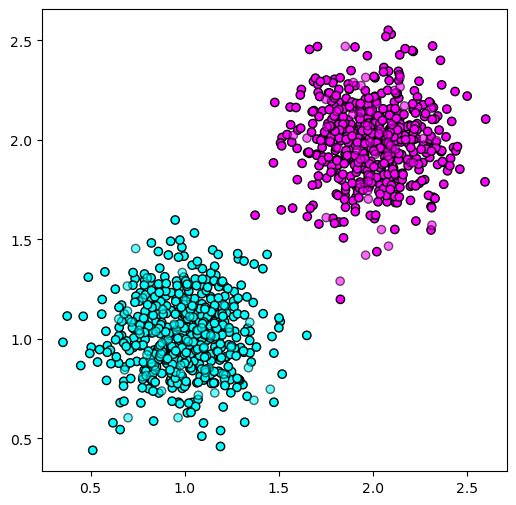

In [5]:
# Plot Data
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

X = np.array([s[0] for s in train_datasets[0].samples])
y = [s[1] for s in train_datasets[0].samples]
ax.scatter(
    X[:, 0], X[:, 1], c=y, cmap="cool", edgecolors="k"
)


X = np.array([s[0] for s in test_dataset.samples])
y = [s[1] for s in test_dataset.samples]
ax.scatter(
    X[:, 0], X[:, 1], c=y, cmap="cool", edgecolors="k", alpha=0.6
)

plt.show()

In [6]:
accuracies = {
    "val": {},
    "test": {},
    "train": {}
}
for lr, trainers_lr in trainers.items():
    print(f"LR {lr}...")
    accuracies["val"][lr] = {}
    accuracies["test"][lr] = {}
    accuracies["train"][lr] = {}
    for name, trainer_list in trainers_lr.items():
        accuracies["val"][lr][name] = []
        accuracies["test"][lr][name] = []
        accuracies["train"][lr][name] = []

        # if name == "lfp-zplus-zminus":
        #     retrain_models = True
        # else:
        #     retrain_models = False

        for t, trainer in enumerate(trainer_list):
            ckpt_path = os.path.join(savepath, f"ckpts-lr-{lr}")
            os.makedirs(ckpt_path, exist_ok=True)
            savename=f"{name}-model-{t}"
            saveappendage="last"
            if retrain_models or not os.path.exists(os.path.join(ckpt_path, f"{savename}-{saveappendage}.pt")):
                #print(f"Training {t+1}-th trainer for propagator {name}...")
                trainer.train(epochs=epochs, verbose=False, savepath=ckpt_path, savename=savename, saveappendage=saveappendage, fromscratch=True)
            else:
                #print(f"Loading checkpoint {os.path.join(ckpt_path, f'{savename}-{saveappendage}.pt')}")
                trainer.load(savepath=ckpt_path, savename=savename, saveappendage=saveappendage)
            res = trainer.eval(datamodes=["test", "val", "train"])
            #print(f'(Test Accuracy) {res["test"]["accuracy"]}')
            accuracies["val"][lr][name].append(res["val"]["accuracy"])
            accuracies["test"][lr][name].append(res["test"]["accuracy"])
            accuracies["train"][lr][name].append(res["train"]["accuracy"])

LR 1e-10...
tensor([[-0.0000, 0.3118],
        [-0.0000, 0.3280],
        [-0.0000, 0.3003],
        [-0.0000, 0.2995],
        [-0.0000, 0.0000],
        [-0.0000, 0.0000],
        [-0.0000, 0.2584],
        [-0.0000, 0.3126],
        [-0.0000, 0.0000],
        [-0.0000, 0.3260],
        [-0.0000, 0.2071],
        [-0.0000, 0.2856],
        [-0.0000, 0.2880],
        [-0.0000, 0.2918],
        [-0.0000, 0.3085],
        [-0.0000, 0.3114],
        [-0.0000, 0.0000],
        [-0.0000, 0.0000],
        [-0.0000, 0.3276],
        [-0.0000, 0.3061],
        [-0.0000, 0.3048],
        [-0.0000, 0.2773],
        [-0.0000, 0.0000],
        [-0.0000, 0.0000],
        [-0.0000, 0.2567],
        [-0.0000, 0.2925],
        [-0.0000, 0.2891],
        [-0.0000, 0.3305],
        [-0.0000, 0.2862],
        [-0.0000, 0.3136],
        [-0.0000, 0.3073],
        [-0.0000, 0.2985],
        [-0.0000, 0.2795],
        [-0.0000, 0.0000],
        [-0.0000, 0.0000],
        [-0.0000, 0.3206],
        [-0.0000

KeyboardInterrupt: 

In [7]:
# Plot Settings
# Set font properties.
import matplotlib.font_manager as font_manager
font_path = plt.matplotlib.get_data_path() + "/fonts/ttf/cmr10.ttf"
cmfont = font_manager.FontProperties(fname=font_path)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = cmfont.get_name()
plt.rcParams["mathtext.fontset"] = "cm"

# Set font size.
plt.rcParams["font.size"] = 15

# Disable unicode minus.
plt.rcParams["axes.unicode_minus"] = False

# Use mathtext for axes formatters.
plt.rcParams["axes.formatter.use_mathtext"] = True

plt.rcParams['axes.linewidth'] = 1.5

### Plot Val Accuracies Over LR

val
MAX: lfp-epsilon - 0.00030000000000000003


/tmp/ipykernel_569723/2396430374.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


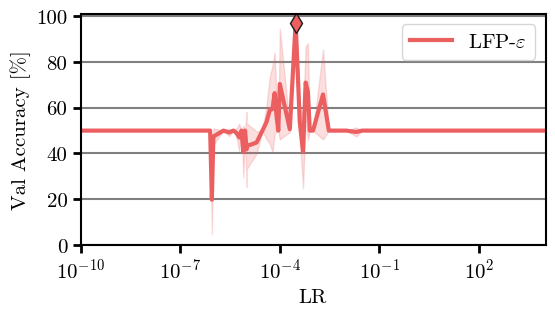

test
MAX: lfp-epsilon - 0.00030000000000000003


/tmp/ipykernel_569723/2396430374.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


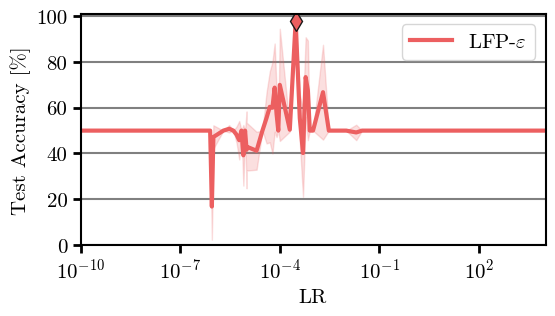

train
MAX: lfp-epsilon - 0.00030000000000000003


/tmp/ipykernel_569723/2396430374.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


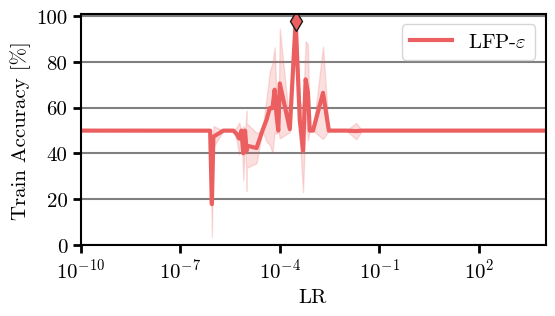

In [8]:
import matplotlib.cm as cm

def plot_accuracies(accuracy_res, name, fname, colormap="Set1"):
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))

    lrs = np.sort([k for k in accuracy_res.keys()])
    methods = [m for m in accuracy_res[lrs[0]].keys()]

    colors = np.linspace(0, 1, 9)
    palette = cm.get_cmap(colormap)(colors)
    pastel = 0.3
    palette = (1-pastel)*palette+pastel*np.ones((9, 4))

    LABELS = {
            "lfp-epsilon": r"LFP-$\varepsilon$",
            "lfp-zplus-zminus": r"LFP-$z^+z^-$",
            "vanilla-gradient": r"Grad",
        }


    maxacclrs = []

    for m, method in enumerate(methods):
        plot_means = []
        plot_stds = []
        for lr in lrs:
            plot_means.append(np.mean(accuracy_res[lr][method]))
            plot_stds.append(np.std(accuracy_res[lr][method]))

        plot_means = np.array(plot_means)
        plot_stds = np.array(plot_stds)

        maxx = lrs[np.argmax(plot_means)]
        maxy = np.max(plot_means)
        print(f"MAX: {method} - {maxx}")
        maxacclrs.append((method, maxx, maxy))

        ax.plot(lrs, plot_means, color=palette[m], label=LABELS[method], linewidth=3, alpha=1)
        ax.plot(maxx, maxy, color=palette[m], marker="d", markersize=10, markeredgecolor=(0.1, 0.1, 0.1, 1))
        ax.fill_between(lrs, plot_means+plot_stds, plot_means-plot_stds, color=palette[m], alpha=0.2)


    linelocs = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    ax.hlines(linelocs, xmin=-1, xmax=lrs[-1], color=(0.5, 0.5, 0.5, 1), linewidth=1.5, zorder=0)
    
    ax.legend()
    ax.set_xscale('log')

    if name == "test":
        nam = "Test"
    if name == "train":
        nam = "Train"
    if name == "val":
        nam = "Val"

    ax.set_ylabel(f"{nam} Accuracy [%]")
    ax.set_xlabel("LR")
    ax.set_ylim([0.0, 1.01])
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([0, 20, 40, 60, 80, 100])
    ax.set_xlim([lrs[0], lrs[-1]])
    ax.tick_params(length=6, width=2)
    #ax.set_xlim([0, 10e-2])
    plt.show()
    fig.savefig(fname)

    return maxacclrs

maxacclrs = {}
for name, val in accuracies.items():
    print(name)
    fname = os.path.join(savepath, f"accuracy-{name}.svg")
    maxacclrs[name] = plot_accuracies(val, name, fname)

### Plot Train/Val Accuracies over steps for best performing models

lfp-epsilon 0.00030000000000000003 0.978


/tmp/ipykernel_569723/2528739069.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


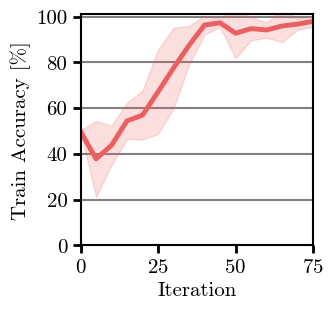

In [9]:
def plot_accuracies_over_epochs(accuracy_logs, fname, colormap="Set1"):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    datasplit = [m for m in accuracy_logs[0].keys() if m == "train"]

    colors = np.linspace(0, 1, 9)
    palette = cm.get_cmap(colormap)(colors)
    pastel = 0.3
    palette = (1-pastel)*palette+pastel*np.ones((9, 4))

    for s, split in enumerate(datasplit):
        plot_data = [accuracy_logs[i][split] for i in range(len(accuracy_logs))]
        plot_means = np.mean(plot_data, axis=0)
        plot_stds = np.std(plot_data, axis=0)

        xaxis = np.arange(0, len(plot_means))*5

        ax.plot(xaxis, plot_means, color=palette[s], label=split, linewidth=3.5, alpha=1)
        ax.fill_between(xaxis, plot_means+plot_stds, plot_means-plot_stds, color=palette[s], alpha=0.2)

    linelocs = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    ax.hlines(linelocs, xmin=-1, xmax=xaxis[-1], color=(0.5, 0.5, 0.5, 1), linewidth=1.5, zorder=0)

    ax.set_ylabel(f"Train Accuracy [%]")
    ax.set_xlabel("Iteration")
    ax.set_ylim([0.0, 1.01])
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_xlim([0.0, xaxis[-1]])
    ax.set_yticklabels([0, 20, 40, 60, 80, 100])
    ax.tick_params(length=6, width=2)
    #ax.set_xlim([0, 200])
    #ax.legend()
    plt.show()
    fig.savefig(fname)

toplot = maxacclrs["test"]
for name, lr, acc in toplot:
    print(name, lr, acc)
    plot_accuracies_over_epochs([trainer.accuracy_log for trainer in trainers[lr][name]], fname = os.path.join(savepath, f"accuracy-lr-{lr}-{name}.svg"))

### Plot Decision Boundaries

lfp-epsilon 0.00030000000000000003 0.978
(52875, 2)


/tmp/ipykernel_569723/4016744574.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colormap, 256)
/tmp/ipykernel_569723/4016744574.py:44: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in cnt.collections:


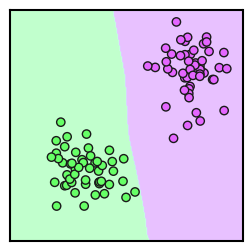

In [10]:
def plot_classifier_boundaries(models, dataset, xlim=(0.25, 2.5), ylim=(0.25, 2.6), colormap="gist_rainbow", fname = ""):
    xgrid = np.arange(xlim[0], xlim[1], 0.01)
    ygrid = np.arange(ylim[0], ylim[1], 0.01)

    xx, yy = np.meshgrid(xgrid, ygrid)
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    grid = np.hstack((r1,r2))

    from matplotlib.colors import ListedColormap
    pastel=0.4
    cmap = cm.get_cmap(colormap, 256)
    newcolors = [cmap(np.linspace(0.4, 0.92, 128))]
    newcolors = (1-pastel)*np.repeat(newcolors, 2, axis=1)[0]+pastel*np.ones((256, 4))
    colormap = ListedColormap(newcolors.clip(max=1))

    edgecolor=np.ones(4)*0.1

    # from matplotlib.colors import ListedColormap
    # colors = np.linspace(0, 1, 9)
    # palette = cm.get_cmap(colormap)(colors)
    # pastel = 0.0
    # palette = (1-pastel)*palette+pastel*np.ones((9, 4))
    # reduced_palette = np.array([palette[2], palette[8], palette[3]]) #green, grey, purple
    # colormap = ListedColormap(reduced_palette)

    yhats = []
    for model in models:

        yhat = torch.nn.functional.softmax(model(torch.from_numpy(grid).float().to(device)), dim=1).detach().cpu().numpy()
        #yhats.append(np.argmax(yhat, axis=1)/yhat.shape[1])
        yhats.append(yhat)


    yhat_mean = np.mean(yhats, axis=0)
    print(yhat_mean.shape)
    yhat_mean = np.argmax(yhat, axis=1)
    #yhat_std = np.std(yhats, axis=0)

    zz = yhat_mean.reshape(xx.shape)

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    cnt = ax.contourf(xx, yy, zz, cmap=colormap, alpha=0.4)
    for c in cnt.collections:
        c.set_edgecolor("face")
        c.set_linewidth(0.000000000001)

    samples = copy.deepcopy(dataset.samples)
    np.random.shuffle(samples)
    #samples = samples[:200]

    X = np.array([s[0] for s in samples])
    y = [s[1] for s in samples]
    ax.scatter(
        X[:, 0], X[:, 1], c=y, cmap=colormap, edgecolors=edgecolor, alpha=1, marker="o"
    )

    ax.set_xticks([])
    ax.set_yticks([])
    #plt.axis("off")

    plt.show()

    fig.savefig(fname)

toplot = maxacclrs["test"]
# for lr in pl_lrs:
#     print("LR", lr)
#     for name, trainer_list in trainers[lr].items():
for name, lr, acc in toplot:
    print(name, lr, acc)
    plot_classifier_boundaries([trainer.model for trainer in trainers[lr][name]], test_dataset, fname = os.path.join(savepath, f"boundary-lr-{lr}-name-{name}.svg"))

Init


/tmp/ipykernel_569723/1234583680.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)
/home/lweber/anaconda3/envs/lxtenv/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


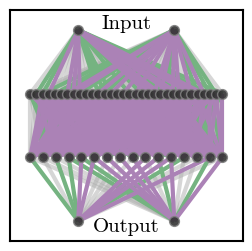

lfp-epsilon 0.00030000000000000003 0.978


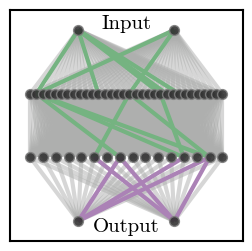

In [12]:
import networkx as nx
from lfp.model.model_definitions import ToyDataDense

def visualize_weights(model, fname, colormap="PRGn"):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    G = nx.Graph()
    layers = [module for module in model.modules() if not isinstance(module, torch.nn.Sequential) and not isinstance(module, ToyDataDense) and not isinstance(module, torch.nn.ReLU) and not isinstance(module, torch.nn.LeakyReLU)]

    colors = np.linspace(0.15, 0.85, 3)
    palette = cm.get_cmap(colormap)(colors)
    pastel = 0.3
    palette = (1-pastel)*palette+pastel*np.ones((3, 4))
    palette[1] *= (0.7, 0.7, 0.7, 0.5)

    nodes = []
    pos = {}
    edges = {"pos": [], "neg": [], "neutral": []}
    edge_colors = {"pos": [], "neg": [], "neutral": []}
    edge_alphas = {"pos": [], "neg": [], "neutral": []}
    for l, layer in enumerate(layers):
        #print([l for l in layer.named_parameters()])
        weights = layer.weight.data.detach().cpu().numpy()
        e_alphas = np.abs(weights)
        e_alphas /= np.max(e_alphas)
        # e_alphas *= 0.9
        # e_alphas += 0.1

        if l == 0:
            # Construct Input

            #print(weights)

            for i in range(weights.shape[1]):
                xcoords = np.linspace(-0.5, 0.5, weights.shape[1])
                nodename = f"I-{i}"
                nodes.append(nodename)
                pos[nodename] = (xcoords[i], len(layers)-1)
        
        for i in range(weights.shape[0]):
            xcoords = np.linspace(-1, 1, weights.shape[0]) if l != len(layers)-1 else np.linspace(-0.5, 0.5, weights.shape[0])
            nodename = f"L{l+1}-{i}" if l != len(layers)-1 else f"O-{i}"
            nodes.append(nodename)
            pos[nodename] = (xcoords[i], len(layers)-1-l-1)

            for j in range(weights.shape[1]):
                pre = f"L{l}-{j}" if l > 0 else f"I-{j}"

                if weights[i][j] > 0 and e_alphas[i][j] > 0.33:
                    color = palette[2]
                    edges["pos"].append((pre, nodename))
                    edge_colors["pos"].append(color)
                    edge_alphas["pos"].append(e_alphas[i][j])
                elif weights[i][j] < 0 and e_alphas[i][j] > 0.33:
                    color = palette[0]
                    edges["neg"].append((pre, nodename))
                    edge_colors["neg"].append(color)
                    edge_alphas["neg"].append(e_alphas[i][j])
                else:
                    color = palette[1]
                    edges["neutral"].append((pre, nodename))
                    edge_colors["neutral"].append(color)
                    edge_alphas["neutral"].append(e_alphas[i][j])


    options = {"edgecolors": "tab:gray", "node_size": 50, "alpha": 0.9}
    nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=(0.2, 0.2, 0.2, 1.0), ax=ax, **options)
    collection_neutral = nx.draw_networkx_edges(
        G,
        pos,
        edgelist=edges["neutral"],
        width=3,
        #alpha=1.0, #edge_alphas,
        edge_color=edge_colors["neutral"],
    )
    collection_neutral.set_zorder(0)

    collection_pos = nx.draw_networkx_edges(
        G,
        pos,
        edgelist=edges["pos"],
        width=3,
        #alpha=1.0, #edge_alphas,
        edge_color=edge_colors["pos"],
    )
    collection_pos.set_zorder(1)

    collection_neg = nx.draw_networkx_edges(
        G,
        pos,
        edgelist=edges["neg"],
        width=3,
        #alpha=1.0, #edge_alphas,
        edge_color=edge_colors["neg"],
    )
    collection_neg.set_zorder(1)

    ax.text(0, len(layers)-0.9, "Input", ha="center", va="center")
    ax.text(0, -1.1, "Output", ha="center", va="center")
    #nx.draw_networkx_labels(G, pos, {n: n for n in nodes}, font_size=15, font_color="black")
    plt.show()
    fig.savefig(fname)

print("Init")

visualize_weights(init_models[0], fname=os.path.join(savepath, f"weights-initmodel.svg"))
for name, lr, acc in toplot:
    print(name, lr, acc)
    visualize_weights(trainers[lr][name][0].model, fname=os.path.join(savepath, f"weights-name-{name}-lr-{lr}.svg"))

lfp-epsilon 0.00030000000000000003
(5, 609)


/tmp/ipykernel_2734213/1829469189.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


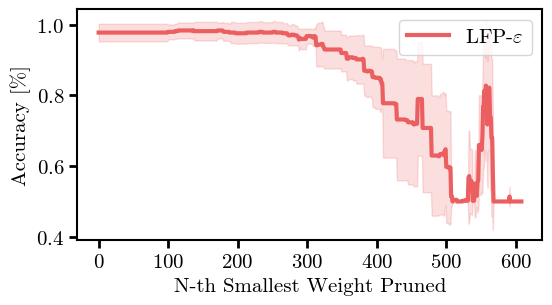

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
def prune_next(model, criterion="min"):
    layers = [module for module in model.modules() if not isinstance(module, torch.nn.Sequential) and not isinstance(module, models.model_definitions.ToyDataDense) and not isinstance(module, torch.nn.ReLU)]

    crit_idx = 0
    if criterion=="min":
        crit_val = np.inf
    else:
        crit_val = -np.inf
    for l, layer in enumerate(layers):
        if criterion == "min":
            w_tmp = torch.where(layer.weight.data.detach().abs() == 0, torch.ones_like(layer.weight.data.detach().abs())*np.inf, layer.weight.data.detach().abs())
            critl = w_tmp.min()
        else:
            w_tmp = torch.where(layer.weight.data.detach().abs() == 0, torch.ones_like(layer.weight.data.detach().abs())*(-np.inf), layer.weight.data.detach().abs())
            critl = w_tmp.max()
        if (criterion == "min" and critl < crit_val) or (criterion == "max" and critl > crit_val):
            crit_val = critl
            crit_idx = l

    if (criterion == "min" and crit_val != np.inf) or (criterion == "max" and crit_val != -np.inf):
        if criterion == "min":
            w_tmp = torch.where(layers[crit_idx].weight.data.abs() == 0, torch.ones_like(layers[crit_idx].weight.data.abs())*np.inf, layers[crit_idx].weight.data.abs())
            widx = torch.argmin(w_tmp)
        else:
            w_tmp = torch.where(layers[crit_idx].weight.data.abs() == 0, torch.ones_like(layers[crit_idx].weight.data.abs())*(-np.inf), layers[crit_idx].weight.data.abs())
            widx = torch.argmax(w_tmp)
        layers[crit_idx].weight.data.view(-1)[widx] = 0.


def get_prune_acc(trainer):
    layers = [module for module in trainer.model.modules() if not isinstance(module, torch.nn.Sequential) and not isinstance(module, models.model_definitions.ToyDataDense) and not isinstance(module, torch.nn.ReLU)]

    numels = 0
    for l, layer in enumerate(layers):
        numels += layer.weight.data.numel()

    prune_accs = [trainer.eval(datamodes=["test"])["test"]["accuracy"]]
    pt = copy.deepcopy(trainer)
    for i in range(numels):
        prune_next(pt.model)
        prune_accs.append(pt.eval(datamodes=["test"])["test"]["accuracy"])

    return prune_accs

def plot_pruning_acc(p_accs, fname, colormap="Set1"):
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))

    colors = np.linspace(0, 1, 9)
    palette = cm.get_cmap(colormap)(colors)
    pastel = 0.3
    palette = (1-pastel)*palette+pastel*np.ones((9, 4))

    LABELS = {
        "lfp-epsilon": r"LFP-$\varepsilon$",
        "lfp-zplus-zminus": r"LFP-$z^+z^-$",
        "vanilla-gradient": r"Grad",
    }

    for m, method in enumerate(list(p_accs.keys())):
        for lr in p_accs[method].keys():
            print(method, lr)
            print(np.shape(p_accs[method][lr]))
            #print(p_accs[method][lr])
            plot_means = np.mean(p_accs[method][lr], axis=0)
            plot_stds = np.std(p_accs[method][lr], axis=0)

            ax.plot(np.arange(len(plot_means)), plot_means, color=palette[m], label=LABELS[method], linewidth=3, alpha=1)
            ax.fill_between(np.arange(len(plot_means)), plot_means+plot_stds, plot_means-plot_stds, color=palette[m], alpha=0.2)

    ax.legend()
    ax.set_ylabel(f"Accuracy [%]")
    ax.set_xlabel("N-th Smallest Weight Pruned")
    ax.tick_params(length=6, width=2)
    plt.show()
    fig.savefig(fname)

p_acc_file = os.path.join(savepath, "p_accs.joblib")
recompute_pacc = True
if not os.path.exists(p_acc_file) or recompute_pacc:
    p_accs = {}
    for name, lr, acc in toplot:
        if name not in p_accs.keys():
            p_accs[name] = {}
            p_accs[name][lr] = []
        for t, trainer in enumerate(trainers[lr][name]):
            prune_acc = get_prune_acc(trainer)
            p_accs[name][lr].append(prune_acc)
    joblib.dump(p_accs, p_acc_file)
else:
    p_accs = joblib.load(p_acc_file)

fname = os.path.join(savepath, "pruning_accuracies.svg")
plot_pruning_acc(p_accs, fname)

lfp-epsilon 0.00030000000000000003
(1, 608, 2)


/tmp/ipykernel_2734213/3358247061.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


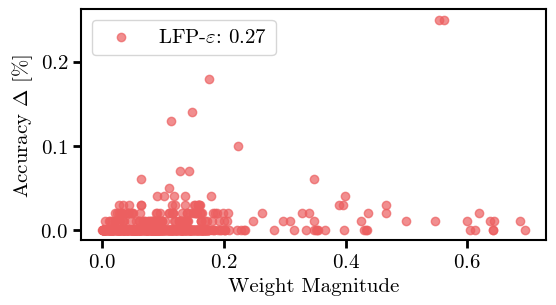

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

def get_prune_acc(trainer):
    layers = [module for module in trainer.model.modules() if not isinstance(module, torch.nn.Sequential) and not isinstance(module, models.model_definitions.ToyDataDense) and not isinstance(module, torch.nn.ReLU)]

    prune_acc_orig = trainer.eval(datamodes=["test"])["test"]["accuracy"]
    prune_accs = []
    for l, layer in enumerate(layers):
        for idx in range(len(layer.weight.data.view(-1))):
            orig_weight = layer.weight.data.view(-1)[idx].item()
            layer.weight.data.view(-1)[idx] = 0.
            prune_accs.append([orig_weight, prune_acc_orig-trainer.eval(datamodes=["test"])["test"]["accuracy"]])
            layer.weight.data.view(-1)[idx] = orig_weight

    return prune_accs

def plot_pruning_scatter(p_accs, fname, colormap="Set1"):
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))

    colors = np.linspace(0, 1, 9)
    palette = cm.get_cmap(colormap)(colors)
    pastel = 0.3
    palette = (1-pastel)*palette+pastel*np.ones((9, 4))

    LABELS = {
        "lfp-epsilon": r"LFP-$\varepsilon$",
        "lfp-zplus-zminus": r"LFP-$z^+z^-$",
        "vanilla-gradient": r"Grad",
    }

    for m, method in enumerate(list(p_accs.keys())):
        for lr in p_accs[method].keys():
            print(method, lr)
            print(np.shape(p_accs[method][lr]))

            corrcoeff = str(np.round(np.corrcoef(np.abs(p_accs[method][lr])[:, :, 0].flatten(), np.abs(p_accs[method][lr])[:, :, 1].flatten())[0, 1], decimals=2))
            ax.scatter(np.abs(p_accs[method][lr])[:, :, 0].flatten(), np.abs(p_accs[method][lr])[:, :, 1].flatten(), color=palette[m], label=LABELS[method]+": "+corrcoeff, alpha=0.7)

    ax.legend()
    ax.set_ylabel(r"Accuracy $\Delta$ [%]")
    ax.set_xlabel("Weight Magnitude")
    ax.tick_params(length=6, width=2)
    plt.show()
    fig.savefig(fname)

p_acc_file = os.path.join(savepath, "p_accs_scatter.joblib")
recompute_pacc = False
if not os.path.exists(p_acc_file) or recompute_pacc:
    p_accs = {}
    for name, lr, acc in toplot:
        if name not in p_accs.keys():
            p_accs[name] = {}
            p_accs[name][lr] = []
        for t, trainer in enumerate(trainers[lr][name]):
            prune_acc = get_prune_acc(trainer)
            p_accs[name][lr].append(prune_acc)
    joblib.dump(p_accs, p_acc_file)
else:
    p_accs = joblib.load(p_acc_file)

fname = os.path.join(savepath, "pruning_accuracies_scatter.svg")
plot_pruning_scatter(p_accs, fname)

In [ ]:
import quanto

q_acc_file = os.path.join(savepath, "q_accs.joblib")
recompute_qacc = False
if not os.path.exists(q_acc_file) or recompute_qacc:
    q_accs = {}
    for name, lr, acc in toplot:
        print(name)
        if name not in q_accs.keys():
            q_accs[name] = {}
            q_accs[name][lr] = []
        for t, trainer in enumerate(trainers[lr][name]):
            q_tr = copy.deepcopy(trainer)
            q_tr.model = copy.deepcopy(trainer.model)
            quanto.quantize(q_tr.model, weights=quanto.qint4)
            quanto.freeze(q_tr.model)

            q_accs[name][lr].append([trainer.eval(datamodes=["test"])["test"]["accuracy"], q_tr.eval(datamodes=["test"])["test"]["accuracy"]])
        print(np.mean(np.array(q_accs[name][lr])[:, 1]), np.mean(np.abs(np.array(q_accs[name][lr])[:, 0] - np.array(q_accs[name][lr])[:, 1])))
    #joblib.dump(p_accs, p_acc_file)
else:
    q_accs = joblib.load(q_acc_file)

#fname = os.path.join(savepath, "pruning_accuracies_scatter.svg")
#plot_pruning_scatter(p_accs, fname)

lfp-epsilon
0.608 0.36999997


/home/lweber/anaconda3/envs/lxtenv/lib/python3.11/site-packages/quanto/library/ops.py:66: UserWarning: An exception was raised while calling the optimized kernel for quanto::unpack: CUDA_HOME environment variable is not set. Please set it to your CUDA install root. Falling back to default implementation.
  warnings.warn(message + " Falling back to default implementation.")
/home/lweber/anaconda3/envs/lxtenv/lib/python3.11/site-packages/quanto/library/ops.py:66: UserWarning: An exception was raised while calling the optimized kernel for quanto::unpack: /home/lweber/.cache/torch_extensions/py311_cu121/quanto_cuda/quanto_cuda.so: cannot open shared object file: No such file or directory Falling back to default implementation.
  warnings.warn(message + " Falling back to default implementation.")


{'init': [{'original': array(0.5, dtype=float32), 'smaller': array(0.48999998, dtype=float32), 'larger': array(0.5, dtype=float32)}], 'lfp-epsilon': [{'original': array(0.95, dtype=float32), 'smaller': array(0.65999997, dtype=float32), 'larger': array(0.5, dtype=float32)}]}
{'init': [{'original': array(0.5, dtype=float32), 'smaller': array(0.48999998, dtype=float32), 'larger': array(0.5, dtype=float32)}], 'lfp-epsilon': [{'original': array(0.95, dtype=float32), 'smaller': array(0.65999997, dtype=float32), 'larger': array(0.5, dtype=float32)}]}


/tmp/ipykernel_2734213/677827345.py:144: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


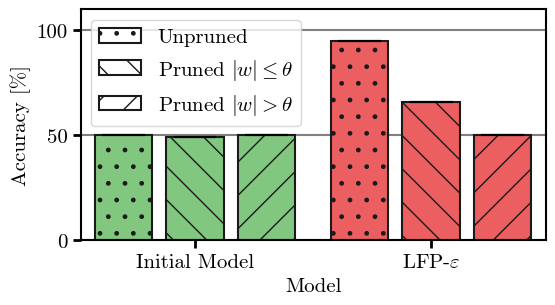

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
def prune_by_threshold(model, threshold=0.33, comparison="larger"):
    layers = [module for module in model.modules() if not isinstance(module, torch.nn.Sequential) and not isinstance(module, models.model_definitions.ToyDataDense) and not isinstance(module, torch.nn.ReLU)]

    for l, layer in enumerate(layers):
        weight_data_norm = layer.weight.data.detach().abs() / layer.weight.data.detach().abs().amax()
        if comparison == "larger":
            weight_data_tmp = torch.where(weight_data_norm > threshold, torch.zeros_like(layer.weight.data), layer.weight.data)
        else:
            weight_data_tmp = torch.where(weight_data_norm <= threshold, torch.zeros_like(layer.weight.data), layer.weight.data)
        layer.weight.data = weight_data_tmp

def get_prune_accs(trainer, threshold=0.33):
    prune_accs = {"original": trainer.eval(datamodes=["test"])["test"]["accuracy"]}

    pt = copy.deepcopy(trainer)
    prune_by_threshold(pt.model, threshold, comparison="smaller")
    prune_accs["smaller"] = pt.eval(datamodes=["test"])["test"]["accuracy"]

    pt = copy.deepcopy(trainer)
    prune_by_threshold(pt.model, threshold, comparison="larger")
    prune_accs["larger"] = pt.eval(datamodes=["test"])["test"]["accuracy"]

    return prune_accs

def plot_pruning_acc(p_accs, fname, colormap="Set1", yoffset=0.0):
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))

    colors = np.linspace(0, 1, 9)
    palette = cm.get_cmap(colormap)(colors)
    palette_tmp = copy.deepcopy(palette)
    palette[0] = palette_tmp[2]
    palette[1] = palette_tmp[0]
    palette[2] = palette_tmp[1]
    pastel = 0.3
    palette = (1-pastel)*palette+pastel*np.ones((9, 4))

    LABELS = {
        "init": "Initial Model",
        "lfp-epsilon": r"LFP-$\varepsilon$",
        "lfp-zplus-zminus": r"LFP-$z^+z^-$",
        "vanilla-gradient": r"Grad",
    }

    LABELS2 = {
        "original": "Unpruned",
        "smaller": r"Pruned $|w|\leq\theta$",
        "larger": r"Pruned $|w|>\theta$",
    }

    HATCHES = {
        "original": ".",
        "smaller": "\\",
        "larger": "/",
    }

    num_prunings = len(HATCHES)

    for m, method in enumerate(list(p_accs.keys())):
        print(p_accs)
        for p, ps in enumerate(list(p_accs[method][0].keys())):

            bar_mean = np.mean([p_accs[method][t][ps] for t in range(len(p_accs[method]))], axis=0)
            bar_std = np.std([p_accs[method][t][ps] for t in range(len(p_accs[method]))], axis=0)

            barloc = m*(num_prunings+0.3)+p
            ax.bar(barloc, bar_mean+yoffset, color=palette[m], bottom=-yoffset, hatch=HATCHES[ps], edgecolor=(0.1, 0.1, 0.1, 1), linewidth=1.5, align="center")
            ax.hlines([bar_mean+yoffset+bar_std], xmin=barloc-0.3, xmax=barloc+0.3, color="black", linewidth=1.5)
            ax.hlines([bar_mean+yoffset-bar_std], xmin=barloc-0.3, xmax=barloc+0.3, color="black", linewidth=1.5)
            ax.vlines([barloc], ymin=bar_mean+yoffset-bar_std, ymax=bar_mean+yoffset+bar_std, color="black", linewidth=1.5)

    legend_handles = []
    # for m, method in enumerate(list(p_accs.keys())):
    #     legend_handles.append(ax.bar([-10], [0.01], color=palette[m], label=LABELS[method], edgecolor=(0.1, 0.1, 0.1, 1), linewidth=1.5))
    for h, hatch in HATCHES.items():
        legend_handles.append(ax.bar([-10], [0.01], color="white", hatch=hatch, label=LABELS2[h], edgecolor=(0.1, 0.1, 0.1, 1), linewidth=1.5))

    linelocs = [0.0, 0.5, 1.0]
    ax.hlines(linelocs, xmin=-1, xmax=400, color=(0.5, 0.5, 0.5, 1), linewidth=1.5, zorder=0)

    ax.legend()
    ax.set_ylim([-yoffset, 1.1])
    ax.set_xlim([-0.6, m*(num_prunings+0.3)+p+0.6])
    ax.set_ylabel(f"Accuracy [%]")
    ax.set_xlabel("Model")
    ax.set_yticks([0.0, 0.5, 1.0])
    ax.set_yticklabels([0, 50, 100])
    ax.set_xticks([m*(num_prunings+0.3)+1 for m in range(len(list(p_accs.keys())))])
    ax.set_xticklabels([LABELS[method] for method in list(p_accs.keys())])
    ax.tick_params(length=6, width=2)
    plt.show()
    fig.savefig(fname)

p_acc_file = os.path.join(savepath, "p_accs_threshold.joblib")
recompute_pacc = False
if not os.path.exists(p_acc_file) or recompute_pacc:
    p_accs = {}
    for name, lr, acc in ([("init", 0.0, 0.0)] + toplot):
        if name not in p_accs.keys():
            p_accs[name] = []
        if name != "init":
            for t, trainer in enumerate(trainers[lr][name]):
                prune_acc = get_prune_accs(trainer)
                p_accs[name].append(prune_acc)
        else:
            # Code is weird but works
            for t, trainer in enumerate(trainers[lrs[0]][list(propagation_composites.keys())[0]]):
                tr = copy.deepcopy(trainer)
                tr.model = init_models[t]
                prune_acc = get_prune_accs(tr)
                p_accs[name].append(prune_acc)
    joblib.dump(p_accs, p_acc_file)
else:
    p_accs = joblib.load(p_acc_file)
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
def prune_by_threshold(model, threshold=0.33, comparison="larger"):
    layers = [module for module in model.modules() if not isinstance(module, torch.nn.Sequential) and not isinstance(module, models.model_definitions.ToyDataDense) and not isinstance(module, torch.nn.ReLU)]

    for l, layer in enumerate(layers):
        weight_data_norm = layer.weight.data.detach().abs() / layer.weight.data.detach().abs().amax()
        if comparison == "larger":
            weight_data_tmp = torch.where(weight_data_norm > threshold, torch.zeros_like(layer.weight.data), layer.weight.data)
        else:
            weight_data_tmp = torch.where(weight_data_norm <= threshold, torch.zeros_like(layer.weight.data), layer.weight.data)
        layer.weight.data = weight_data_tmp

def get_prune_accs(trainer, threshold=0.33):
    prune_accs = {"original": trainer.eval(datamodes=["test"])["test"]["accuracy"]}

    pt = copy.deepcopy(trainer)
    prune_by_threshold(pt.model, threshold, comparison="smaller")
    prune_accs["smaller"] = pt.eval(datamodes=["test"])["test"]["accuracy"]

    pt = copy.deepcopy(trainer)
    prune_by_threshold(pt.model, threshold, comparison="larger")
    prune_accs["larger"] = pt.eval(datamodes=["test"])["test"]["accuracy"]

    return prune_accs

def plot_pruning_acc(p_accs, fname, colormap="Set1", yoffset=0.0):
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))

    colors = np.linspace(0, 1, 9)
    palette = cm.get_cmap(colormap)(colors)
    palette_tmp = copy.deepcopy(palette)
    palette[0] = palette_tmp[2]
    palette[1] = palette_tmp[0]
    palette[2] = palette_tmp[1]
    pastel = 0.3
    palette = (1-pastel)*palette+pastel*np.ones((9, 4))

    LABELS = {
        "init": "Initial Model",
        "lfp-epsilon": r"LFP-$\varepsilon$",
        "lfp-zplus-zminus": r"LFP-$z^+z^-$",
        "vanilla-gradient": r"Grad",
    }

    LABELS2 = {
        "original": "Unpruned",
        "smaller": r"Pruned $|w|\leq\theta$",
        "larger": r"Pruned $|w|>\theta$",
    }

    HATCHES = {
        "original": ".",
        "smaller": "\\",
        "larger": "/",
    }

    num_prunings = len(HATCHES)

    for m, method in enumerate(list(p_accs.keys())):
        print(p_accs)
        for p, ps in enumerate(list(p_accs[method][0].keys())):

            bar_mean = np.mean([p_accs[method][t][ps] for t in range(len(p_accs[method]))], axis=0)
            bar_std = np.std([p_accs[method][t][ps] for t in range(len(p_accs[method]))], axis=0)

            barloc = m*(num_prunings+0.3)+p
            ax.bar(barloc, bar_mean+yoffset, color=palette[m], bottom=-yoffset, hatch=HATCHES[ps], edgecolor=(0.1, 0.1, 0.1, 1), linewidth=1.5, align="center")
            ax.hlines([bar_mean+yoffset+bar_std], xmin=barloc-0.3, xmax=barloc+0.3, color="black", linewidth=1.5)
            ax.hlines([bar_mean+yoffset-bar_std], xmin=barloc-0.3, xmax=barloc+0.3, color="black", linewidth=1.5)
            ax.vlines([barloc], ymin=bar_mean+yoffset-bar_std, ymax=bar_mean+yoffset+bar_std, color="black", linewidth=1.5)

    legend_handles = []
    # for m, method in enumerate(list(p_accs.keys())):
    #     legend_handles.append(ax.bar([-10], [0.01], color=palette[m], label=LABELS[method], edgecolor=(0.1, 0.1, 0.1, 1), linewidth=1.5))
    for h, hatch in HATCHES.items():
        legend_handles.append(ax.bar([-10], [0.01], color="white", hatch=hatch, label=LABELS2[h], edgecolor=(0.1, 0.1, 0.1, 1), linewidth=1.5))

    linelocs = [0.0, 0.5, 1.0]
    ax.hlines(linelocs, xmin=-1, xmax=400, color=(0.5, 0.5, 0.5, 1), linewidth=1.5, zorder=0)

    ax.legend()
    ax.set_ylim([-yoffset, 1.1])
    ax.set_xlim([-0.6, m*(num_prunings+0.3)+p+0.6])
    ax.set_ylabel(f"Accuracy [%]")
    ax.set_xlabel("Model")
    ax.set_yticks([0.0, 0.5, 1.0])
    ax.set_yticklabels([0, 50, 100])
    ax.set_xticks([m*(num_prunings+0.3)+1 for m in range(len(list(p_accs.keys())))])
    ax.set_xticklabels([LABELS[method] for method in list(p_accs.keys())])
    ax.tick_params(length=6, width=2)
    plt.show()
    fig.savefig(fname)

p_acc_file = os.path.join(savepath, "p_accs_threshold.joblib")
recompute_pacc = False
if not os.path.exists(p_acc_file) or recompute_pacc:
    p_accs = {}
    for name, lr, acc in ([("init", 0.0, 0.0)] + toplot):
        if name not in p_accs.keys():
            p_accs[name] = []
        if name != "init":
            for t, trainer in enumerate(trainers[lr][name]):
                prune_acc = get_prune_accs(trainer)
                p_accs[name].append(prune_acc)
        else:
            # Code is weird but works
            for t, trainer in enumerate(trainers[lrs[0]][list(propagation_composites.keys())[0]]):
                tr = copy.deepcopy(trainer)
                tr.model = init_models[t]
                prune_acc = get_prune_accs(tr)
                p_accs[name].append(prune_acc)
    joblib.dump(p_accs, p_acc_file)
else:
    p_accs = joblib.load(p_acc_file)

fname = os.path.join(savepath, "pruning_accuracies_threshold.svg")
plot_pruning_acc(p_accs, fname)